In [38]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
import mapclassify

data = './data'

In [2]:
# Import input files
# Supply locations
s_loc = gpd.read_file('./data/access/input_files/hospital_geocode.json')
s_loc = s_loc.set_index('HC_ID')
s_loc = s_loc.fillna(0)
s_loc.head(1)

,Type,Zip,County,Staffed_Beds,ICU_Beds,FIPS,TSA,lat,lng,geometry
HC_ID,,,,,,,,,,
H000,Short Term Acute Care Hospital,75001,Dallas,32.0,4,48113,E,32.984766,-96.829405,POINT (1295826.606 1205448.145)


In [3]:
d_val = pd.read_csv('./data/reference_data/covid_data/daily_covid_case.csv')
d_val.set_index('County', inplace=True)
d_val = d_val.sum(axis=1)
d_val = pd.DataFrame(d_val, columns=['cases_county'])
d_val.head(1)

,cases_county
County,
Anderson,5877.0


In [4]:
# Demand locations
d_loc = gpd.read_file('./data/reference_data/geographic_units/tract_reference.shp')
d_loc.set_index('County', inplace=True)
d_loc = d_loc.merge(d_val, left_index=True, right_index=True)
d_loc['cases_tract'] = d_loc['pop_ratio'] * d_loc['cases_county']
d_loc.reset_index(inplace=True)
d_loc.set_index('GEOID', inplace=True)
d_loc.head(1)

,County,TSA,pop,pop_ratio,geometry,cases_county,cases_tract
GEOID,,,,,,,
48001950100,Anderson,G,4844,0.083792,"POLYGON ((1405776.557 1097438.688, 1405779.438...",5877.0,492.444006


In [5]:
# Mobility: OD Matrix between supply and demand locations
mobility_df = pd.read_csv('./data/access/input_files/Precalculated_OD_Matrix.csv')
mobility_df['GEOID'] = mobility_df['GEOID'].astype(str)

In [6]:
# DISTANCE DECAY
minutes = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60]
weights = {0: 1, 5: 0.9459, 10: 0.7544, 15: 0.5511, 20: 0.3993, 25: 0.2957, 30: 0.2253, 35: 0.1765, 40: 0.1417, 45: 0.1161, 60: 0.0832}


In [10]:
supply_demand_ratio = s_loc.filter(['ICU_Beds', 'geometry'], axis=1)
supply_demand_ratio['ratio'] = 0.0

# Step 1 of E2SFCA
for s_idx in tqdm(supply_demand_ratio.index):
    temp_supply = s_loc.at[s_idx, 'ICU_Beds']

    temp_ctmt = mobility_df.loc[mobility_df['HC_ID'] == s_idx]

    temp_demand = 0
    for idx, minute in enumerate(minutes):
        if idx != 0:
            temp_ctmt_geoid = temp_ctmt.loc[(minutes[idx - 1] < temp_ctmt['trvl_time'])
                                            & (temp_ctmt['trvl_time'] <= minute), 'GEOID'].to_list()
            temp_demand += d_loc.loc[temp_ctmt_geoid, 'cases_tract'].sum() * weights[minute]
    temp_ratio = temp_supply / temp_demand
    supply_demand_ratio.at[s_idx, 'ratio'] = temp_ratio

supply_demand_ratio.head(1)

100%|█████████████████████████████████████████████| 652/652 [00:16<00:00, 38.72it/s]


,ICU_Beds,geometry,ratio
HC_ID,,,
H000,4,POINT (1295826.606 1205448.145),0.000014


In [22]:
access_tract = d_loc.filter(['County', 'TSA', 'pop', 'geometry'], axis=1)
# access_tract = pd.DataFrame(index=d_loc.index, columns=['static'])
# access_tract = access_tract.fillna(0.0)
access_tract['access'] = 0.0

for d_idx in tqdm(access_tract.index):
    temp_ctmt_2 = mobility_df.loc[mobility_df['GEOID'] == d_idx]
    temp_ratio = 0
    for idx, minute in enumerate(minutes):
        if idx != 0:
            temp_ctmt_hc_id = temp_ctmt_2.loc[(minutes[idx - 1] < temp_ctmt_2['trvl_time'])
                                              & (temp_ctmt_2['trvl_time'] <= minute), 'HC_ID'].to_list()
            temp_ratio += supply_demand_ratio.loc[temp_ctmt_hc_id, 'ratio'].sum() * weights[minute]

    access_tract.at[d_idx, 'access'] = temp_ratio

# access_tract = d_loc.merge(access_tract, left_index=True, right_index=True)
access_tract.head(1)

100%|███████████████████████████████████████████| 5265/5265 [02:17<00:00, 38.40it/s]


,County,TSA,pop,geometry,access
GEOID,,,,,
48001950100,Anderson,G,4844,"POLYGON ((1405776.557 1097438.688, 1405779.438...",0.00281


In [31]:
# access_tract.to_file('./data/access/ICU_access_measures/static_measurement/ICU_access_tract_static.shp')

In [16]:
# County Geometry
county_geom = gpd.read_file(os.path.join(data, 'reference_data', 'geographic_units', 'county_reference.shp'))

# TSA Geometry
tsa_geom = county_geom.dissolve(by='TSA', aggfunc='sum')
tsa_geom.reset_index(inplace=True)

[0.00138915 0.00228743 0.00320943 0.00456502 0.00663502 0.01085837
 0.01621163]


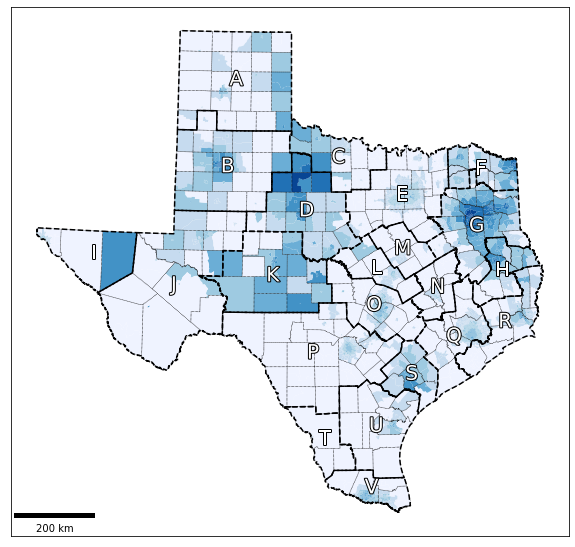

In [48]:
# Define color map
color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

print(mapclassify.NaturalBreaks(access_tract['access'], k=7).bins)

fig, ax = plt.subplots(figsize=(10,10))

access_tract.plot(column='access', 
                  ax = ax,
                  cmap=cm,
                  scheme='NaturalBreaks',
#                   legend=True,
                  k=7
                 )

county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

# ax.text(0.05, 0.95, s='Static', fontsize=30, ha='left', va='top', transform=ax.transAxes)
ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Inequality (Gini)

In [27]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

gini(access_tract['access'])

0.30119920654987253

In [87]:
import numpy as np

In [88]:
np.ones(len(access_tract))

array([1., 1., 1., ..., 1., 1., 1.])

In [86]:
1 * alen(access_tract)

5265

In [100]:
gini(np.ones(len(access_tract)), access_tract['access'])

0.9996790097642911

In [95]:
access_tract['access'].to_numpy().sort()

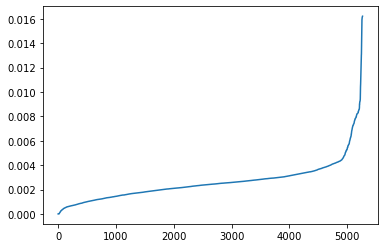

In [99]:
plt.plot(range(len(access_tract)), access_tract['access'])

## Correlation analysis (County-level)

In [65]:
# access_tract = step2.copy(deep=True)
access_county = county_geom.copy(deep=True)
access_county['access'] = 0.0
county_list = county_geom['County'].tolist()

# for date in tqdm(focus_date):
for temp_county in tqdm(county_list):
    temp_pop_tract = access_tract.loc[access_tract['County'] == temp_county, 'pop']
    temp_access_tract = access_tract.loc[access_tract['County'] == temp_county, 'access']

    temp_access_county = sum(temp_pop_tract * temp_access_tract)
    temp_pop_county = access_county.loc[access_county['County'] == temp_county, 'pop'].values[0]

    access_county.loc[access_county['County'] == temp_county, 'access'] = temp_access_county / temp_pop_county

access_county.head(3)

100%|████████████████████████████████████████████| 254/254 [00:00<00:00, 903.13it/s]


,GEOID,TSA,pop,County,geometry,access
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",0.002099
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",0.002414
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",0.005809


In [68]:
# access_county.to_file('./data/access/ICU_access_measures/static_measurement/ICU_access_county_static.shp')

/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

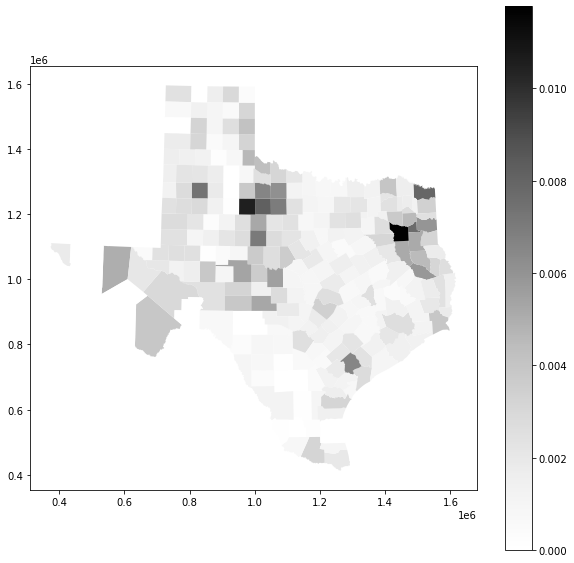

In [69]:
access_county.plot('access', figsize=(10, 10), cmap='Greys', legend=True)

### Import mortlaity / case-fatality-ratio data

In [70]:
death = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'daily_covid_death.csv'))
death = death.set_index('County')
death = death.sum(axis=1)
death = pd.DataFrame(death, columns=['death_county'])
fatality = d_val.merge(death, left_index=True, right_index=True)
fatality.reset_index(inplace=True)
fatality.head(3)

,County,cases_county,death_county
0,Anderson,5877.0,207
1,Andrews,2462.0,65
2,Angelina,6762.0,403


In [71]:
fatality = county_geom.merge(fatality, on='County')
fatality['mortality'] = fatality['death_county'] / fatality['pop'] * 100000
fatality['fatality'] = fatality['death_county'] / fatality['cases_county'] * 1000
fatality.head(3)

,GEOID,TSA,pop,County,geometry,cases_county,death_county,mortality,fatality
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",5877.0,207,358.069538,35.222052
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",2462.0,65,360.390330,26.401300
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",6762.0,403,461.510272,59.597752


<AxesSubplot:>

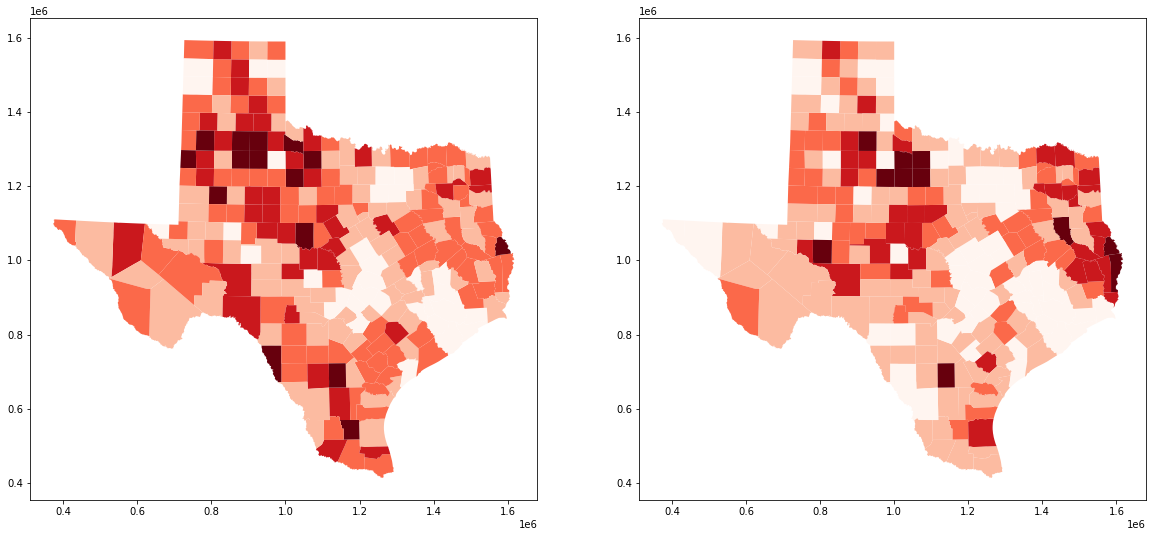

In [72]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))

fatality.plot('mortality', figsize=(10, 10), scheme='FisherJenks', cmap='Reds', ax=axes[0])
fatality.plot('fatality', figsize=(10, 10), scheme='FisherJenks', cmap='Reds', ax=axes[1])

## Corr


In [73]:
access_county

,GEOID,TSA,pop,County,geometry,access
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",0.002099
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",0.002414
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",0.005809
3,48007,U,24462,Aransas,"POLYGON ((1274596.986 661976.640, 1275197.203 ...",0.000872
4,48009,C,8716,Archer,"POLYGON ((1146052.762 1278817.953, 1146055.620...",0.001200
...,...,...,...,...,...,...
249,48499,G,44366,Wood,"POLYGON ((1453300.416 1186211.472, 1453300.470...",0.003769
250,48501,B,8631,Yoakum,"POLYGON ((758198.913 1216450.100, 758196.993 1...",0.002465
251,48503,C,18036,Young,"POLYGON ((1128414.929 1247487.578, 1128741.058...",0.002481
252,48505,T,14304,Zapata,"POLYGON ((1083961.136 569160.648, 1084088.878 ...",0.000144


In [74]:
fatality

,GEOID,TSA,pop,County,geometry,cases_county,death_county,mortality,fatality
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",5877.0,207,358.069538,35.222052
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",2462.0,65,360.390330,26.401300
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",6762.0,403,461.510272,59.597752
3,48007,U,24462,Aransas,"POLYGON ((1274596.986 661976.640, 1275197.203 ...",1858.0,68,277.982176,36.598493
4,48009,C,8716,Archer,"POLYGON ((1146052.762 1278817.953, 1146055.620...",1070.0,24,275.355668,22.429907
...,...,...,...,...,...,...,...,...,...
249,48499,G,44366,Wood,"POLYGON ((1453300.416 1186211.472, 1453300.470...",3704.0,242,545.462742,65.334773
250,48501,B,8631,Yoakum,"POLYGON ((758198.913 1216450.100, 758196.993 1...",708.0,36,417.101147,50.847458
251,48503,C,18036,Young,"POLYGON ((1128414.929 1247487.578, 1128741.058...",2315.0,74,410.290530,31.965443
252,48505,T,14304,Zapata,"POLYGON ((1083961.136 569160.648, 1084088.878 ...",1644.0,45,314.597315,27.372263


In [75]:
kendalltau(access_county['access'], fatality['fatality'])

KendalltauResult(correlation=0.11374646082344692, pvalue=0.0069621416938617986)

In [78]:
def normalize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.min()) / (ary.max() - ary.min())
        
    return ary_

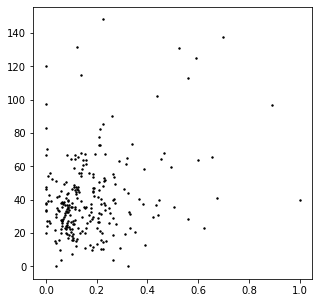

In [79]:
fig, ax = plt.subplots(figsize=(5,5))

# Kendall's tau correlation at State Level
# print(kendalltau(corr_state['access'], corr_state['mortality']))
ax.scatter(normalize(access_county['access']), fatality['fatality'],  color='black', s=2)

In [80]:
print(gini(X))

0.30119920654987253


0.30119920654987253


Text(0, 0.5, 'Cumulative proportion of hexagons')

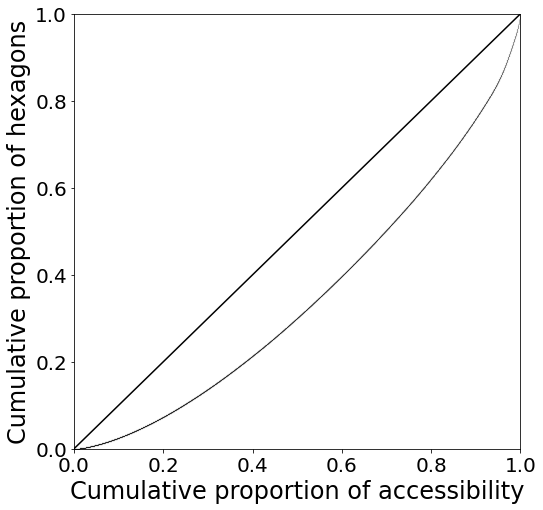

In [56]:
fig, ax = plt.subplots(figsize=[8,8])

plot_colors = ['#377eb8', '#e41a1c', '#ff7f00']
# for idx, ratio in enumerate(['p05', 'p50', 'p95']):
# for date in ['07/06/2020', '07/13/2020', '07/20/2020', '07/27/2020', '08/03/2020', '08/10/2020', '08/17/2020', '08/24/2020', '08/31/2020', '09/07/2020', '09/14/2020', '09/21/2020', '09/28/2020', '10/05/2020', '10/12/2020', '10/19/2020', '10/26/2020', '11/02/2020', '11/09/2020', '11/16/2020', '11/23/2020', '11/30/2020', '12/07/2020', '12/14/2020', '12/21/2020', '12/28/2020', '01/04/2021', '01/11/2021', '01/18/2021', '01/25/2021', '02/01/2021', '02/08/2021', '02/15/2021', '02/22/2021', '03/01/2021', '03/08/2021', '03/15/2021', '03/22/2021', '03/29/2021', '04/05/2021', '04/12/2021', '04/19/2021', '04/26/2021', '05/03/2021', '05/10/2021', '05/17/2021', '05/24/2021', '05/31/2021', '06/07/2021', '06/14/2021', '06/21/2021', '06/28/2021', '07/05/2021', '07/12/2021', '07/19/2021', '07/26/2021', '08/02/2021', '08/09/2021', '08/16/2021', '08/23/2021', '08/30/2021', '09/06/2021', '09/13/2021', '09/20/2021', '09/27/2021', '10/04/2021', '10/11/2021', '10/18/2021', '10/25/2021', '11/01/2021', '11/08/2021', '11/15/2021', '11/22/2021', '11/29/2021', '12/06/2021', '12/13/2021', '12/20/2021', '12/27/2021', '07/01/2020']:
X = access_tract['access'].to_numpy(copy=True)
print(gini(X))
#     X = measures[f'{ratio}'].to_numpy(copy=True)
X.sort()

X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]

## scatter plot of Lorenz curve
ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
           marker='.', s=0.01, color='black')
## line plot of equality
ax.plot([0,1], [0,1], color='k')
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlim(xmin=0, xmax=1)
ax.set_ylim(ymin=0, ymax=1)
ax.set_xlabel('Cumulative proportion of accessibility', fontsize=24)
ax.set_ylabel('Cumulative proportion of hexagons', fontsize=24)


In [227]:
def gini_JP(temp_df, var_x, var_y):
    '''
    input: 
    temp_df: DataFrame with two columns representing two variables
    var_x: varaible which denotes number of locations, population or confirmed COVID-19 cases
    var_y: variable which denotes accessibility
    
    output: 
    '''
    
    # Sort dataframe based on the accessibility
    temp_df = temp_df.copy(deep=True)
    temp_df.sort_values(by=var_y, inplace=True)
    
    # Calculate cumulative distribution of accessibility 
    y_ = temp_df[var_y].cumsum() / temp_df[var_y].sum()
    y_ = y_.to_numpy()
    
    # Calculate cumulative distribution of locations, population or confirmed COVID-19 cases
    if var_x == 'locations':
        x_ = np.ones(temp_df.shape[0]).cumsum() / np.ones(temp_df.shape[0]).sum() 

    else:
        x_ = temp_df[var_x].cumsum() / temp_df[var_x].sum()
        x_ = x_.to_numpy()
    
    # Insert value 0 at the beginning of both array to faciliate the calculation of area drawn from Lorenz curve
    x_ = np.insert(x_, 0, 0, axis=0)
    y_ = np.insert(y_, 0, 0, axis=0)
    
    # Calculate area below Lorenz curve
    area_ = 0.0
    for i in range(1, len(x_)):
        area_ += (x_[i] - x_[i-1]) * (y_[i] + y_[i-1]) / 2. # Calculate area of parallelogram

    gini_coef = (0.5 - area_) / 0.5
        
    return gini_coef, x_, y_

In [228]:
gini_a, x_, y_ = gini_JP(access_tract[['pop', 'access']], 'pop', 'access')

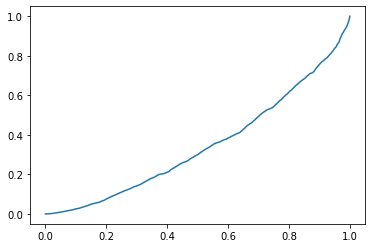

In [230]:
plt.plot(x_, y_)

In [229]:
access_tract

,County,TSA,pop,geometry,access
GEOID,,,,,
48001950100,Anderson,G,4844,"POLYGON ((1405776.557 1097438.688, 1405779.438...",0.000000
48001950401,Anderson,G,4838,"POLYGON ((1392461.585 1072740.298, 1392447.163...",0.000000
48001950402,Anderson,G,7511,"POLYGON ((1379516.856 1075774.243, 1379519.198...",0.000000
48001950500,Anderson,G,4465,"POLYGON ((1407370.327 1079167.289, 1407397.255...",0.000000
48001950600,Anderson,G,5148,"POLYGON ((1405841.667 1069714.758, 1405850.031...",0.000000
...,...,...,...,...,...
48505950400,Zapata,T,5399,"POLYGON ((1054099.250 568270.286, 1054111.585 ...",0.016151
48507950100,Zavala,P,1448,"POLYGON ((1016211.351 736231.712, 1016347.303 ...",0.016152
48507950200,Zavala,P,1608,"POLYGON ((989065.623 752780.785, 989069.717 75...",0.016152


In [213]:
gini_JP(access_tract.filter(['pop', 'access'], axis=1), 'locations', 'access')

0.3011992065498752

In [211]:
gini_JP(access_tract.filter(['pop', 'access'], axis=1), 'locations', 'access')

0.3011992065498752

In [164]:
inequality.gini.Gini(gini_cal['access']).g

0.3011992065498749

In [106]:
gini_cal = access_tract.filter(['pop', 'access'], axis=1)

gini_cal.sort_values(by='access', inplace=True)
gini_cal

,pop,access
GEOID,,
48001950100,4844,0.000000
48005000101,6346,0.000000
48003950400,3377,0.000000
48003950300,4889,0.000000
48003950200,7465,0.000000
...,...,...
48505950400,5399,0.016151
48507950100,1448,0.016152
48507950200,1608,0.016152


In [201]:
y = gini_cal['access'].cumsum() / gini_cal['access'].sum()
# x = gini_cal['access']
y = y.to_numpy()
y

array([0.        , 0.        , 0.        , ..., 0.99766085, 0.99882977,
       1.        ])

In [202]:
x = gini_cal['pop'].cumsum() / gini_cal['pop'].sum()

In [193]:
# x = np.ones(gini_cal.shape[0]).cumsum() / np.ones(gini_cal.shape[0]).sum() 

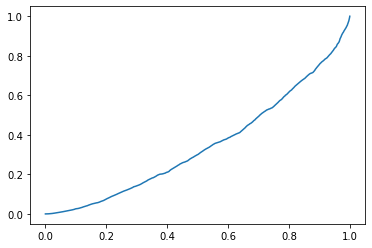

In [203]:
plt.plot(x, y)

In [204]:
area = 0.0
for i in range(1, len(x)):
    area += (x[i] - x[i-1]) * (y[i] + y[i-1]) / 2.
area

(0.5 - area) / 0.5

0.3071007897815963

In [161]:
import inequality

0.3011992065498752